In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load engineered features
df = pd.read_csv("../data/nifty_model_features.csv")

df.head()


,Datetime,Close,High,Low,Open,Volume,EMA_5,EMA_15,Returns
0,2025-10-24 03:50:00+00:00,25886.000000,25892.400391,25840.400391,25851.150391,0.0,25862.533854,25855.200684,0.001362
1,2025-10-24 03:55:00+00:00,25886.400391,25893.300781,25859.500000,25886.300781,0.0,25870.489366,25859.100647,0.000015
2,2025-10-24 04:00:00+00:00,25875.400391,25887.599609,25864.500000,25885.849609,0.0,25872.126374,25861.138115,-0.000425
3,2025-10-24 04:05:00+00:00,25914.300781,25914.699219,25862.550781,25876.150391,0.0,25886.184510,25867.783448,0.001503
4,2025-10-24 04:10:00+00:00,25903.500000,25913.300781,25883.449219,25913.199219,0.0,25891.956340,25872.248017,-0.000417


In [2]:
df["Rolling_Return"] = df["Returns"].rolling(20).mean()
df["Rolling_Volatility"] = df["Returns"].rolling(20).std()

df[["Rolling_Return", "Rolling_Volatility"]].head(25)


,Rolling_Return,Rolling_Volatility
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


regime classification

In [3]:
def classify_regime(row):
    if row["Rolling_Return"] > 0 and row["Rolling_Volatility"] < 0.002:
        return "Uptrend"
    elif row["Rolling_Return"] < 0 and row["Rolling_Volatility"] < 0.002:
        return "Downtrend"
    else:
        return "Sideways"

df["Regime"] = df.apply(classify_regime, axis=1)

df = df.dropna().reset_index(drop=True)

df["Regime"].value_counts()


Regime
Downtrend    2190
Uptrend      2042
Name: count, dtype: int64

Visualize price by regime

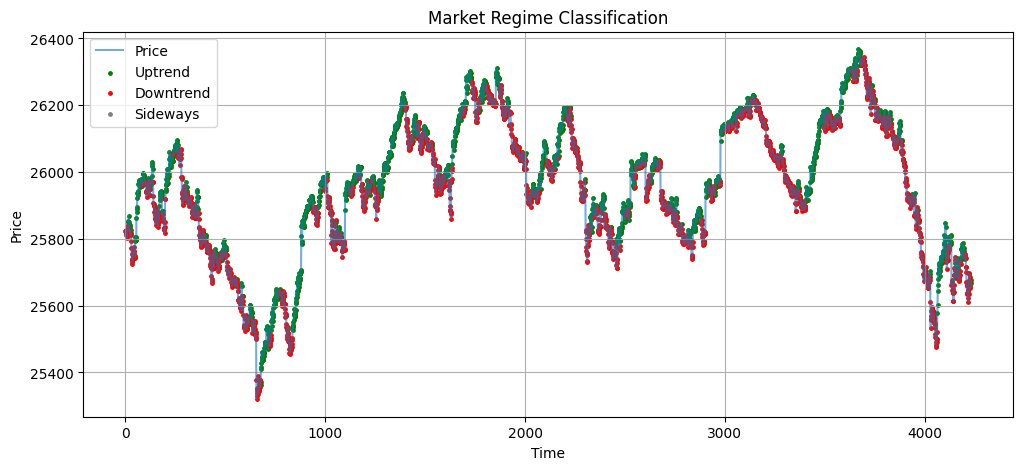

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(df["Close"], label="Price", alpha=0.6)

colors = {
    "Uptrend": "green",
    "Downtrend": "red",
    "Sideways": "gray"
}

for regime, color in colors.items():
    mask = df["Regime"] == regime
    plt.scatter(df.index[mask], df["Close"][mask],
                color=color, s=6, label=regime)

plt.title("Market Regime Classification")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


Regime-filtered EMA strategy

In [5]:
df["Regime_Signal"] = 0

df.loc[
    (df["EMA_5"] > df["EMA_15"]) & (df["Regime"] == "Uptrend"),
    "Regime_Signal"
] = 1

df.loc[
    (df["EMA_5"] < df["EMA_15"]) & (df["Regime"] == "Downtrend"),
    "Regime_Signal"
] = -1

df["Regime_Return"] = df["Regime_Signal"].shift(1) * df["Returns"]
df["Regime_Cumulative"] = (1 + df["Regime_Return"]).cumprod()

df[["Regime_Cumulative"]].tail()


,Regime_Cumulative
4227,0.996210
4228,0.996210
4229,0.995927
4230,0.995329
4231,0.995329


Regime-filtered strategy performance

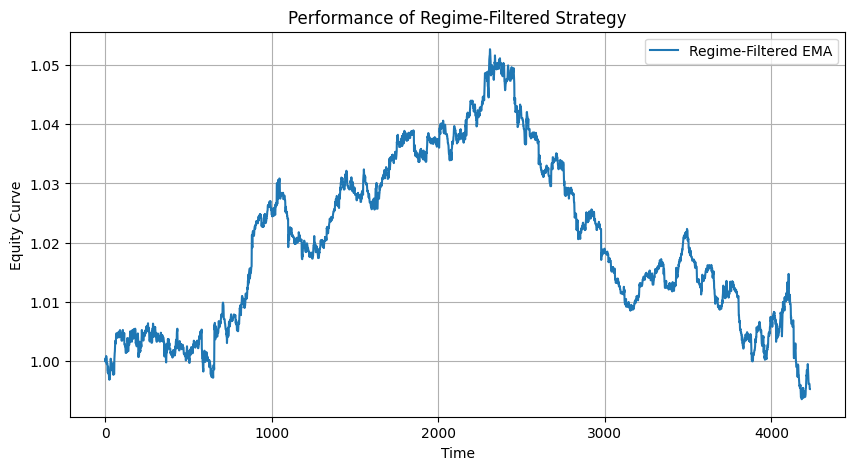

In [6]:
os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(df["Regime_Cumulative"], label="Regime-Filtered EMA")
plt.xlabel("Time")
plt.ylabel("Equity Curve")
plt.title("Performance of Regime-Filtered Strategy")
plt.legend()
plt.grid(True)

plt.savefig("../plots/regime_filtered_equity.png", dpi=300, bbox_inches="tight")
plt.show()


In [7]:
df.to_csv("../data/regime_strategy_results.csv", index=False)

print("Market regime analysis completed successfully")


Market regime analysis completed successfully


In [8]:
transition_matrix = pd.crosstab(
    df["Regime"].shift(1),
    df["Regime"],
    normalize="index"
)

transition_matrix


Regime,Downtrend,Uptrend
Regime,,
Downtrend,0.911416,0.088584
Uptrend,0.094561,0.905439


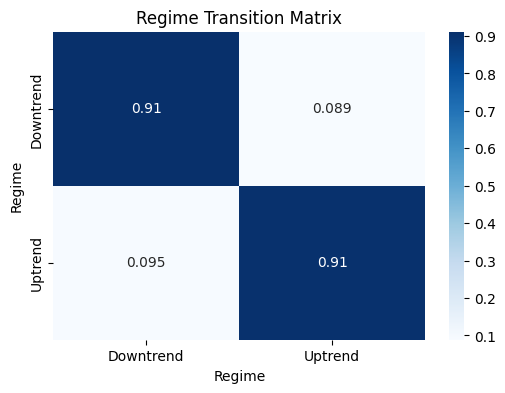

In [9]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(transition_matrix, annot=True, cmap="Blues")
plt.title("Regime Transition Matrix")
plt.show()


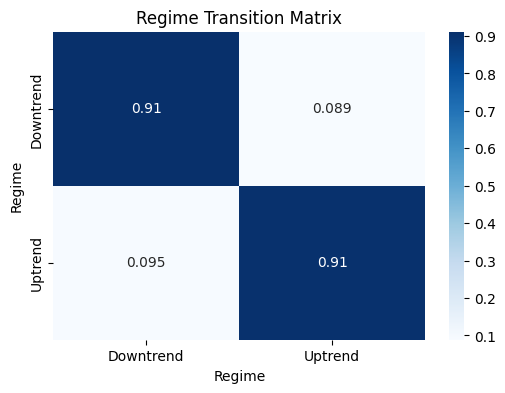

In [10]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(transition_matrix, annot=True, cmap="Blues")
plt.title("Regime Transition Matrix")
plt.show()


In [11]:
plt.savefig("../plots/regime_transition_matrix.png", dpi=300)


<Figure size 640x480 with 0 Axes>